In [115]:
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [41]:
path_to_json = 'howest_dataset/'
dataset= pd.DataFrame()
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for json_file in json_files:
    json_file=path_to_json+json_file
    with open(json_file) as train_file:
        dict_train = json.load(train_file)
    file_df=pd.DataFrame.from_dict(pd.json_normalize(dict_train), orient='columns')
    dataset=dataset.append(file_df,ignore_index = True)

In [42]:
dataset.drop(['client_reference','mail_subject','party_id','party_type','unit_id','organization','from_mail','comments'], axis=1, inplace=True) 

In [43]:
def text_processing(content):
    text_no_html = BeautifulSoup(str(content),"html.parser" ).get_text()
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
    text_lower = text_alpha_chars.lower()
    stops = set(stopwords.words('dutch')) 
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
    return text_no_stop_words

def get_fileNames(attachment):
    fileNames=[]
    for obj in attachment:
        fileNames.append(obj['filename'].replace('.pdf', ''))
        fileNamesStr = ' '.join(fileNames)
    return fileNamesStr

def get_content(attachment):
    contents=[]
    for obj in attachment:
        contents.append(obj['content'])
        contentsStr = ' '.join(contents)
        contentsStr=text_processing(contentsStr)
    return contentsStr
    
dataset['mail_content']=dataset['mail_content'].apply(text_processing)
dataset['attachments_filename']=dataset['attachments'].apply(get_fileNames)
dataset['attachments_content']=dataset['attachments'].apply(get_content)
dataset.drop('attachments', axis=1, inplace=True) 

In [44]:
dataset_nl=dataset.loc[dataset['language']=='nl_BE']
dataset_fr=dataset.loc[dataset['language']=='fr_BE']
dataset_nl.drop('language', axis=1, inplace=True) 
dataset_fr.drop('language', axis=1, inplace=True)

/Users/alechantson/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [45]:
dataset_nl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2541 entries, 2 to 3672
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   mail_content            2541 non-null   object
 1   labels.assignment_type  2541 non-null   object
 2   labels.case_type        2541 non-null   object
 3   labels.sub_case_type    2541 non-null   object
 4   labels.damage_type      2541 non-null   object
 5   attachments_filename    2541 non-null   object
 6   attachments_content     2541 non-null   object
dtypes: object(7)
memory usage: 158.8+ KB


In [46]:
dataset_nl.head()

,mail_content,labels.assignment_type,labels.case_type,labels.sub_case_type,labels.damage_type,attachments_filename,attachments_content
2,bijlage wij document betrekking opdracht toev...,Unilateral,Property,Fire,Storm,"MISSION_ASSIGNEMENT foto foto Offerte 3.406,12...",nv koning bic btw be verzekeringsmaatschappij...
4,bijlage wij document betrekking opdracht toev...,Bilateral,Property,Fire,Collision,courtier envoie le devis et confirme le compte...,from kantoor custers date december to beheer ...
5,sans mevrouw contacteren verzekeraar bijlage ...,Unilateral,Property,Fire,Collision,Foto's van de schade Polis Feel At Home Aangif...,from sent fri sep to subject betreft nr klant...
6,sans mevrouw contacteren verzekeraar bijlage ...,Unilateral,Property,Fire,WaterDamage,Polis Grimonprez Rapport lekdetectie Bestek sc...,historiek num contract ris schade num beschri...
7,sans mevrouw contacteren verzekeraar bijlage ...,Bilateral,Liability,Operations,WaterDamage,DOCUMENT 0309808_08-13-2020_320116257 0336257_...,historiek num contract ris schade num beschri...


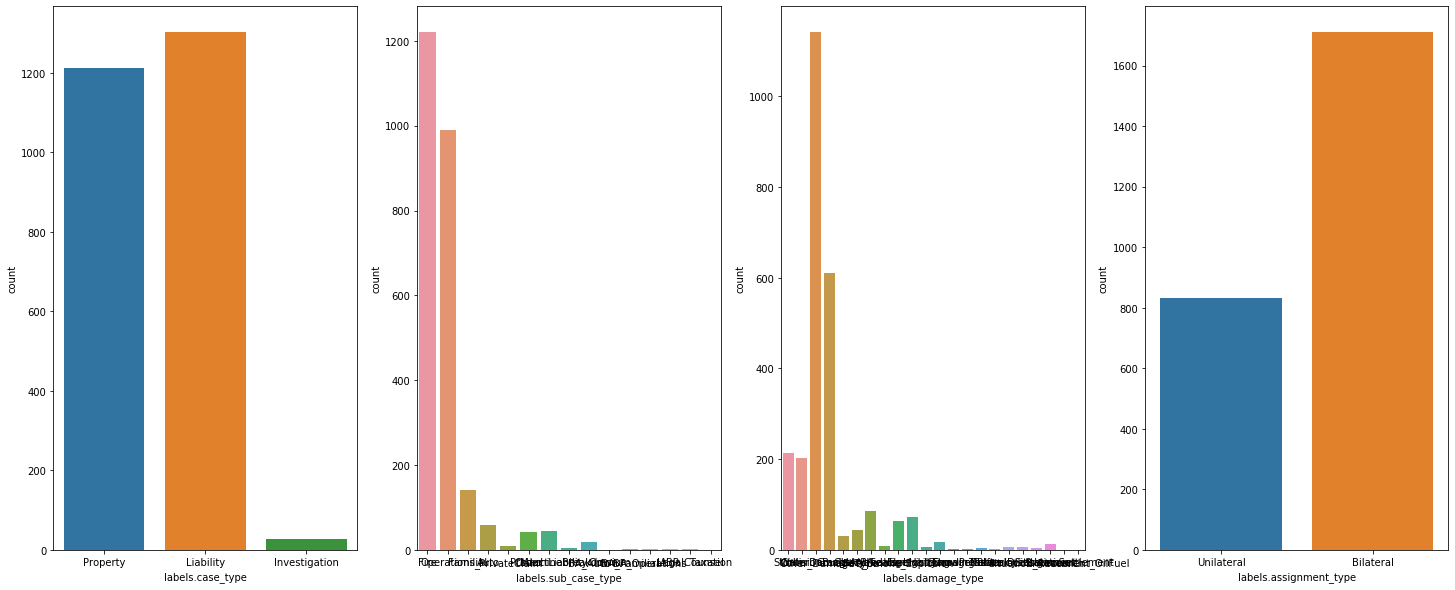

In [47]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=dataset_nl,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=dataset_nl,ax=ax[1])
sns.countplot(x='labels.damage_type',data=dataset_nl,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=dataset_nl,ax=ax[3])

In [321]:
y_nl=dataset_nl[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X_nl=dataset_nl.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type'], axis=1)

In [322]:
y_nl

,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
2,Property,Fire,Storm,Unilateral
4,Property,Fire,Collision,Bilateral
5,Property,Fire,Collision,Unilateral
6,Property,Fire,WaterDamage,Unilateral
7,Liability,Operations,WaterDamage,Bilateral
...,...,...,...,...
3667,Property,Fire,WaterDamage,Unilateral
3669,Liability,Operations,WaterDamage,Bilateral
3670,Liability,Auto,Other_DamageType,Bilateral
3671,Property,Fire,WaterDamage,Unilateral


In [323]:
# X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl,y_nl, test_size = 0.30, random_state = 0)
# print(X_train_nl.shape,Y_train_nl.shape)
# print(X_test_nl.shape,Y_test_nl.shape)

In [324]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 2500#NIET GEBRUKT
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [325]:
X_nl['content']=dataset[dataset.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)

In [326]:
X_nl.drop(['mail_content','attachments_filename','attachments_content'],axis=1)

,content
2,bijlage wij document betrekking opdracht toev...
4,bijlage wij document betrekking opdracht toev...
5,sans mevrouw contacteren verzekeraar bijlage ...
6,sans mevrouw contacteren verzekeraar bijlage ...
7,sans mevrouw contacteren verzekeraar bijlage ...
...,...
3667,bijlage wij document betrekking opdracht toev...
3669,sans mevrouw contacteren verzekeraar bijlage ...
3670,bijlage wij document betrekking opdracht toev...
3671,bijlage wij document betrekking opdracht toev...


In [327]:
tokenizer.fit_on_texts(X_nl['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_nl = tokenizer.texts_to_sequences(X_nl['content'].values)
X_nl = pad_sequences(X_nl)
print('Shape of data tensor:', X_nl.shape)

Found 42719 unique tokens.
Shape of data tensor: (2541, 33425)


In [316]:
#EVEN NEGEREN
# tokenizer.fit_on_texts(X_train_nl['attachments_filename'].values)
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# X_train_attFileName_nl = tokenizer.texts_to_sequences(X_train_nl['attachments_filename'].values)
# X_train_attFileName_nl = pad_sequences(X_train_attFileName_nl)
# print('Shape of data tensor:', X_train_attFileName_nl.shape)
# X_test_attFileName_nl = tokenizer.texts_to_sequences(X_test_nl['attachments_filename'].values)
# X_test_attFileName_nl = pad_sequences(X_test_attFileName_nl)
# print('Shape of data tensor:', X_test_attFileName_nl.shape)

In [317]:
#EVEN NEGEREN
# tokenizer.fit_on_texts(X_train_nl['attachments_content'].values)
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# X_train_attContent_nl = tokenizer.texts_to_sequences(X_train_nl['attachments_content'].values)
# X_train_attContent_nl = pad_sequences(X_train_attContent_nl)
# print('Shape of data tensor:', X_train_attContent_nl.shape)
# X_test_attContent_nl = tokenizer.texts_to_sequences(X_test_nl['attachments_content'].values)
# X_test_attContent_nl = pad_sequences(X_test_attContent_nl)
# print('Shape of data tensor:', X_test_attContent_nl.shape)

In [328]:
y_nl= pd.get_dummies(y_nl)
print('Shape of label tensor:', y_nl.shape)

Shape of label tensor: (2541, 42)


In [329]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl,y_nl, test_size = 0.30, random_state = 42)
print(X_train_nl.shape,y_train_nl.shape)
print(X_test_nl.shape,y_test_nl.shape)

(1778, 33425) (1778, 42)
(763, 33425) (763, 42)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_nl.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(42, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train_nl,y_train_nl,epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
10/25 [===========>..................] - ETA: 25:09 - loss: 14.8317 - accuracy: 0.0689